## Note: Elasticsearch for Semantic Search

Objective is to demonstrate semantic search.

https://www.kaggle.com/datasets/arpansri/books-summary

https://www.cs.cmu.edu/~dbamman/booksummaries.html

- Implements semantic search by using SentenceTransformer("all-MiniLM-L6-v2")
  - kNN with pre-filter by using term
- Implements semantic search by using SentenceTransformer("google/embeddinggemma-300m")
  - kNN with post filter by using term
- ELSER (requires subscription), sparse vector

In [6]:
%%capture
%pip install --user elasticsearch
%pip install --user sentence-transformers

In [4]:
from elasticsearch import Elasticsearch
from elasticsearch import helpers
import pandas as pd
import json

Let's load configuration data from a file

In [21]:
from dotenv import dotenv_values
config_filename = 'es_kibana.cfg'
config = dotenv_values(config_filename)
if config['ELASTIC_PASSWORD'] is None:
    print(f"No {config_filename} file not found!")
else:
    ELASTIC_PASSWORD = config['ELASTIC_PASSWORD']


## Connect to Elasticsearch
Let's connect to Elasticsearch

In [22]:
#
client = Elasticsearch([{'host': 'localhost', 'port': 9200, "scheme": "http"}]
                       , basic_auth=("elastic", ELASTIC_PASSWORD)
                       )

Let's print the metadata attached to Elasticsearch client object

In [23]:
client.info()

ObjectApiResponse({'name': '8bb798e2995b', 'cluster_name': 'docker-cluster', 'cluster_uuid': 'bvhUZ6w4T2Wv-eDmKDDmBQ', 'version': {'number': '9.1.5', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '90ee222e7e0136dd8ddbb34015538f3a00c129b7', 'build_date': '2025-10-02T22:07:12.966975992Z', 'build_snapshot': False, 'lucene_version': '10.2.2', 'minimum_wire_compatibility_version': '8.19.0', 'minimum_index_compatibility_version': '8.0.0'}, 'tagline': 'You Know, for Search'})

In [24]:
answer = client.info()
print(type(answer))

# Custom made; elastic_transport.ObjectApiResponse is a dict
for k in answer.keys():
    if k == 'version':
        print(f"{k} :")
        for k2 in answer[k]:
            print(f"\t{k2} : {answer[k][k2]}")
    else:
        print(f"{k} : {answer[k]}")

<class 'elastic_transport.ObjectApiResponse'>
name : 8bb798e2995b
cluster_name : docker-cluster
cluster_uuid : bvhUZ6w4T2Wv-eDmKDDmBQ
version :
	number : 9.1.5
	build_flavor : default
	build_type : docker
	build_hash : 90ee222e7e0136dd8ddbb34015538f3a00c129b7
	build_date : 2025-10-02T22:07:12.966975992Z
	build_snapshot : False
	lucene_version : 10.2.2
	minimum_wire_compatibility_version : 8.19.0
	minimum_index_compatibility_version : 8.0.0
tagline : You Know, for Search


Test that we can create an index.

In [10]:
response = None
try:
    response = client.indices.create(index="my-index")
    print(response)
except Exception as e:
    print(e)

{'acknowledged': True, 'shards_acknowledged': True, 'index': 'my-index'}


Delete an index

In [16]:
response=client.indices.delete(index="books_index", ignore_unavailable=True)
print(response)

{'acknowledged': True}


In [17]:
filename="./books_summary.csv"
df = pd.read_csv(filename)
df[:10]

,Unnamed: 0,book_name,summaries,categories
0,0,The Highly Sensitive Person,is a self-assessment guide and how-to-live te...,science
1,1,Why Has Nobody Told Me This Before?,is a collection of a clinical psychologist’s ...,science
2,2,The Midnight Library,"tells the story of Nora, a depressed woman in...",science
3,3,Brave New World,presents a futuristic society engineered perf...,science
4,4,1984,is the story of a man questioning the system ...,science
5,5,Stolen Focus,explains why our attention spans have been dw...,science
6,6,The Life-Changing Science of Detecting Bullshit,teaches its readers how to avoid falling for ...,science
7,7,Dopamine Nation,talks about the importance of living a balance...,science
8,8,The Art of Statistics,is a non-technical book that shows how statis...,science
9,9,No Self No Problem,is a provocative read about the implications ...,science


In [36]:
books = pd.DataFrame(columns=['title', 'summaries', 'categories'])
books['title'] = df['book_name']
books['summaries'] = df['summaries']
books['categories'] = df['categories']
books[:10]

,title,summaries,categories
0,The Highly Sensitive Person,is a self-assessment guide and how-to-live te...,science
1,Why Has Nobody Told Me This Before?,is a collection of a clinical psychologist’s ...,science
2,The Midnight Library,"tells the story of Nora, a depressed woman in...",science
3,Brave New World,presents a futuristic society engineered perf...,science
4,1984,is the story of a man questioning the system ...,science
5,Stolen Focus,explains why our attention spans have been dw...,science
6,The Life-Changing Science of Detecting Bullshit,teaches its readers how to avoid falling for ...,science
7,Dopamine Nation,talks about the importance of living a balance...,science
8,The Art of Statistics,is a non-technical book that shows how statis...,science
9,No Self No Problem,is a provocative read about the implications ...,science


In [89]:
print(books.shape)
print(f"Number of rows: {books.shape[0]}")


(5201, 3)
Number of rows: 5201


## Text Embedding

In [7]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")

In [10]:
for i in range(0,4):
    dense_vector=model.encode(df.iloc[i]['summaries'])
    print(f"{df.iloc[i]['summaries'][:25]} => {dense_vector[:5]}")

 is a self-assessment gui => [-0.00457442  0.06466927  0.01546645  0.0779688   0.00655783]
 is a collection of a cli => [-0.04709079  0.06510939  0.03502083  0.07370524 -0.054125  ]
 tells the story of Nora, => [-0.00266549 -0.00708092 -0.03312564  0.06194825  0.04316377]
 presents a futuristic so => [ 0.00179127  0.03210582 -0.08147258 -0.00509052  0.0581198 ]


## Create an Index
Let's create a books index

In [16]:
columns = ["Field Name","Field Data Type","Notes"]
data = [ {"Field Name":"title","Field Data Type":"integer","Notes":"searchable text content"},
         {"Field Name":"summaries","Field Data Type":"text","Notes":"searchable text content, search by name"},
         {"Field Name":"categories","Field Data Type":"text","Notes":"searchable text content, search by category"},
         ]
dfm = pd.DataFrame(data=data,columns = columns)
dfm

,Field Name,Field Data Type,Notes
0,title,integer,searchable text content
1,summaries,text,"searchable text content, search by name"
2,categories,text,"searchable text content, search by category"


<Axes: xlabel='Count', ylabel='categories'>

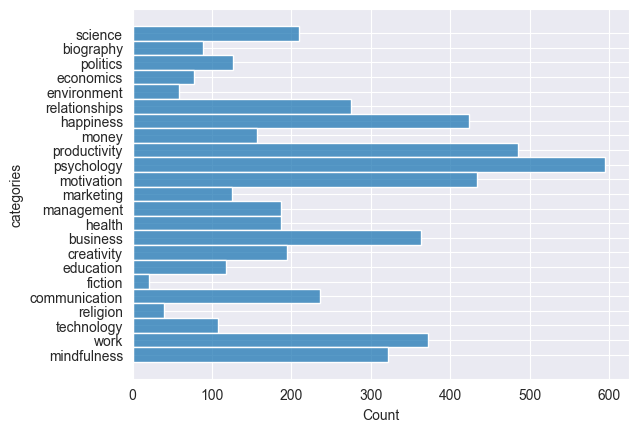

In [18]:
import seaborn as sns
sns.histplot(data=df, y="categories")

Define index

In [19]:
books_mappings = {
 "properties": {
      "title": {
        "type": "text",      ## searchable text content, search by title
      },
      "categories": {
        "type": "text",      ## searchable text content, search by category
      },
      "summaries": {
        "type": "text",  ## searchable text content
      },
     "summary_dense_vector": {
            "type": "dense_vector",
            "dims": 384,    ## because of text embedding ("all-MiniLM-L6-v2")
            "index": "true",
            "similarity": "cosine",
        },
    },
}

In [83]:
response=client.indices.delete(index="books_index", ignore_unavailable=True)
print(response)

{'acknowledged': True}


In [84]:
# Create the index
client.indices.create(index="books_index", mappings=books_mappings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'books_index'})

In [85]:
response = client.indices.get(index="books_index")
print(response)

{'books_index': {'aliases': {}, 'mappings': {'properties': {'categories': {'type': 'text'}, 'summaries': {'type': 'text'}, 'summary_dense_vector': {'type': 'dense_vector', 'dims': 384, 'index': True, 'similarity': 'cosine', 'index_options': {'type': 'bbq_hnsw', 'm': 16, 'ef_construction': 100, 'rescore_vector': {'oversample': 3.0}}}, 'title': {'type': 'text'}}}, 'settings': {'index': {'routing': {'allocation': {'include': {'_tier_preference': 'data_content'}}}, 'number_of_shards': '1', 'provided_name': 'books_index', 'creation_date': '1763332790181', 'number_of_replicas': '1', 'uuid': 'zCRorktFQ2S6DTC7l7evhw', 'version': {'created': '9033000'}}}}}


In [41]:
def books_index_add(r):
    doc = {
        "title": r["title"],
        "categories": r["categories"],
        "summaries": r["summaries"],
        "summary_dense_vector": r["summary_dense_vector"],
    }
    response = client.index(index="books_index", body=doc)
    return response['result']


In [ ]:
book = books.iloc[1]
book["summary_dense_vector"] = model.encode(book["summaries"]).tolist()
document = books_index_add(book.to_dict())
response = client.index(index="books_index", body=document)
response


Load all books data, apply text embedding on 'summaries' of book

In [ ]:
# Load data
for i in range(0,books.shape[0]):
    # Apply text embedding by using SentenceTransformers
    book = books.iloc[i].to_dict()
    book["summary_dense_vector"] = model.encode(book["summaries"]).tolist()
    document = books_index_add(book)
    response = client.index(index="books_index", body=document)



In [78]:
# Helper function
def pretty_response(response):
    if len(response["hits"]["hits"]) == 0:
        print("Your search returned no results.")
    else:
        print(f"Number of hits: {len(response["hits"]["hits"])}")
        for hit in response["hits"]["hits"]:
            id = hit["_id"]
            score = hit["_score"]
            title = hit["_source"]["title"]
            summary = hit["_source"]["summaries"]
            categories = hit["_source"]["categories"]
            pretty_output = f"\nID: {id}\nTitle: {title}\nCategories: {categories}\nSummary: {summary}\nScore: {score}"
            print(pretty_output)

In [68]:
# Builds a document for kNN request on dense vector...
def build_knn_doc_from_query(model, query,k=10,numc=100):
    knn = {
        "field": "summary_dense_vector",
        "query_vector": model.encode(query).tolist(),
        "k": k,
        "num_candidates": numc,
    }
    return knn


In [ ]:
# query : "living a balanced life"
reply = build_knn_doc_from_query(model,"living a balanced life")
reply

In [70]:
# semantic_search helper function
def semantic_search(model, query, k=10, num_candidates=100):
    response = client.search(
        index="books_index",
        knn={
            "field": "summary_dense_vector",
            "query_vector": model.encode(query).tolist(),
            "k": k,
            "num_candidates": num_candidates,
        },
    )
    return response

Test

In [92]:
response = semantic_search(model, "living a balanced life")
pretty_response(response)

Number of hits: 10

ID: d83WjpoBHNu-EPBTAYZO
Title: Dopamine Nation
Categories: science
Summary: talks about the importance of living a balanced life in relation to all the pleasure and stimuli we’re surrounded with on a daily basis, such as drugs, devices, porn, gambling facilities, showing us how to avoid becoming dopamine addicts by restricting our access to them. 
Score: 0.8082686

ID: gc3WjpoBHNu-EPBTA4b-
Title: Dopamine Nation
Categories: science
Summary: talks about the importance of living a balanced life in relation to all the pleasure and stimuli we’re surrounded with on a daily basis, such as drugs, devices, porn, gambling facilities, showing us how to avoid becoming dopamine addicts by restricting our access to them. 
Score: 0.8082686

ID: Ds3WjpoBHNu-EPBTKYf9
Title: Emotional Agility
Categories: science
Summary:  provides a new, science-backed approach to navigating life’s many trials and detours on your path to fulfillment, with which you’ll face your emotions head on, ob

In [93]:
response = semantic_search(model, "engineered future society")
pretty_response(response)

Number of hits: 10

ID: c83WjpoBHNu-EPBTAIY6
Title: Brave New World
Categories: science
Summary:  presents a futuristic society engineered perfectly around capitalism and scientific efficiency, in which everyone is happy, conform, and content — but only at first glance.
Score: 0.8303348

ID: fc3WjpoBHNu-EPBTAobm
Title: Brave New World
Categories: science
Summary:  presents a futuristic society engineered perfectly around capitalism and scientific efficiency, in which everyone is happy, conform, and content — but only at first glance.
Score: 0.8303348

ID: nM3WjpoBHNu-EPBTToe0
Title: Brave New World
Categories: politics
Summary:  presents a futuristic society engineered perfectly around capitalism and scientific efficiency, in which everyone is happy, conform, and content — but only at first glance.
Score: 0.8303348

ID: ps3WjpoBHNu-EPBTUYdJ
Title: Brave New World
Categories: politics
Summary:  presents a futuristic society engineered perfectly around capitalism and scientific efficienc

In [119]:
# helper to convert ES query response to dataframe
def response_to_dataFrame(response):
    ret = pd.DataFrame(columns=['id', 'score', 'title', 'categories', 'summaries'])
    if len(response["hits"]["hits"]) > 0:
        for hit in response["hits"]["hits"]:
            arow = {}
            arow['id'] = hit['_id']
            arow['score'] = hit['_score']
            arow['title'] = hit['_source']['title']
            arow['categories'] = hit['_source']['categories']
            arow['summaries'] = hit['_source']['summaries']
            #arowdf = pd.DataFrame.from_dict(arow)
            ret = ret._append(arow, ignore_index=True)
            #print(arow)
    return ret


In [121]:
response_df = response_to_dataFrame(response)
response_df

C:\Users\timuc\AppData\Local\Temp\ipykernel_32752\136793328.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ret = ret._append(arow, ignore_index=True)


,id,score,title,categories,summaries
0,c83WjpoBHNu-EPBTAIY6,0.830335,Brave New World,science,presents a futuristic society engineered perf...
1,fc3WjpoBHNu-EPBTAobm,0.830335,Brave New World,science,presents a futuristic society engineered perf...
2,nM3WjpoBHNu-EPBTToe0,0.830335,Brave New World,politics,presents a futuristic society engineered perf...
3,ps3WjpoBHNu-EPBTUYdJ,0.830335,Brave New World,politics,presents a futuristic society engineered perf...
4,G83WjpoBHNu-EPBTb4jF,0.830335,Brave New World,economics,presents a futuristic society engineered perf...
5,JM3WjpoBHNu-EPBTcogJ,0.830335,Brave New World,economics,presents a futuristic society engineered perf...
6,tc3WjpoBHNu-EPBTl4i-,0.830335,Brave New World,relationships,presents a futuristic society engineered perf...
7,I83WjpoBHNu-EPBTL4dQ,0.777334,The Singularity Is Near,science,outlines the future of technology by describi...
8,Lc3WjpoBHNu-EPBTMYfh,0.766144,Abundance,science,shows you the key technological trends being ...
9,Fs3WjpoBHNu-EPBTboiA,0.749036,Superintelligence,politics,asks what will happen once we manage to build...


## Filter output of semantic search with terms

In [122]:
# semantic_search helper function
def semantic_search_with_filter(model, query, filter, k=10, num_candidates=100):
    response = client.search(
        index="books_index",
        knn={
            "field": "summary_dense_vector",
            "query_vector": model.encode(query).tolist(),
            "k": k,
            "num_candidates": num_candidates,
            "filter": filter,
        },
    )
    return response

In [124]:
myfilter ={}
myCategory ={}
myCategory['categories']='politics'
myfilter['term']=myCategory
response = semantic_search_with_filter(model, "engineered future society",filter=myfilter)
pretty_response(response)

Number of hits: 10

ID: nM3WjpoBHNu-EPBTToe0
Title: Brave New World
Categories: politics
Summary:  presents a futuristic society engineered perfectly around capitalism and scientific efficiency, in which everyone is happy, conform, and content — but only at first glance.
Score: 0.8303348

ID: ps3WjpoBHNu-EPBTUYdJ
Title: Brave New World
Categories: politics
Summary:  presents a futuristic society engineered perfectly around capitalism and scientific efficiency, in which everyone is happy, conform, and content — but only at first glance.
Score: 0.8303348

ID: Fs3WjpoBHNu-EPBTboiA
Title: Superintelligence
Categories: politics
Summary:  asks what will happen once we manage to build computers that are smarter than us, including what we need to do, how it’s going to work, and why it has to be done the exact right way to make sure the human race doesn’t go extinct.
Score: 0.74903595

ID: 5s3WjpoBHNu-EPBTYocN
Title: Cradle To Cradle
Categories: politics
Summary:  uncovers the hidden problems w

In [125]:
response_df = response_to_dataFrame(response)
response_df

C:\Users\timuc\AppData\Local\Temp\ipykernel_32752\136793328.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ret = ret._append(arow, ignore_index=True)


,id,score,title,categories,summaries
0,nM3WjpoBHNu-EPBTToe0,0.830335,Brave New World,politics,presents a futuristic society engineered perf...
1,ps3WjpoBHNu-EPBTUYdJ,0.830335,Brave New World,politics,presents a futuristic society engineered perf...
2,Fs3WjpoBHNu-EPBTboiA,0.749036,Superintelligence,politics,asks what will happen once we manage to build...
3,5s3WjpoBHNu-EPBTYocN,0.733252,Cradle To Cradle,politics,uncovers the hidden problems with manufacturi...
4,o83WjpoBHNu-EPBTUIeF,0.723205,The Sovereign Individual,politics,jumps into the future and presents a new worl...
5,rc3WjpoBHNu-EPBTU4cZ,0.723205,The Sovereign Individual,politics,jumps into the future and presents a new worl...
6,oM3WjpoBHNu-EPBTT4fA,0.716834,The Dawn of Everything,politics,tells the story of how we went from hunter-ga...
7,qs3WjpoBHNu-EPBTUodR,0.716834,The Dawn of Everything,politics,tells the story of how we went from hunter-ga...
8,nc3WjpoBHNu-EPBTTof0,0.714470,1984,politics,is the story of a man questioning the system ...
9,p83WjpoBHNu-EPBTUYeJ,0.714470,1984,politics,is the story of a man questioning the system ...


## DSL

https://www.elastic.co/docs/reference/query-languages/query-dsl/query-dsl-knn-query

In [155]:
import json

query="living a balanced life"
K=10
term_dict = {}
term_dict['categories'] = 'science'

knn_dict = {}
knn_dict['k'] = K
knn_dict['num_candidates'] = 100
knn_dict['field'] = 'summary_dense_vector'
knn_dict['query_vector'] = model2.encode(query).tolist()

myCategory = {}
myfilter = {}
myCategory['categories']='science'
myfilter['term'] = myCategory
knn_dict['filter'] = myfilter

semantic_query_pre_filter = {
    "query": {
        "knn": knn_dict
    },
}

#print(semantic_query_pre_filter)
print(json.dumps(semantic_query_pre_filter,indent=2))

{
  "query": {
    "knn": {
      "k": 10,
      "num_candidates": 100,
      "field": "summary_dense_vector",
      "query_vector": [
        -0.15519817173480988,
        0.05757518857717514,
        0.03750494867563248,
        0.025255102664232254,
        -0.0009233343880623579,
        -0.01421528123319149,
        -0.036501694470644,
        0.06713427603244781,
        0.04430089518427849,
        0.008518683724105358,
        0.018470702692866325,
        -0.028555793687701225,
        0.04746529459953308,
        -0.03296573832631111,
        0.038970477879047394,
        -0.023782391101121902,
        -0.02360418066382408,
        -0.005933609325438738,
        0.007494394667446613,
        -0.022481931373476982,
        -0.03677431493997574,
        -0.04817723110318184,
        -0.023522770032286644,
        0.023178009316325188,
        0.032309871166944504,
        0.04260842502117157,
        0.025155819952487946,
        0.0026862670201808214,
        0.002367020584642

# Summary

# Appendix

## Use Gemma Embedding

In [127]:
model2 = SentenceTransformer("google/embeddinggemma-300m")


modules.json:   0%|          | 0.00/573 [00:00<?, ?B/s]

C:\Users\timuc\AppData\Roaming\Python\Python313\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\timuc\.cache\huggingface\hub\models--google--embeddinggemma-300m. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/997 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/18.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/58.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.49k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.21G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/312 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

2_Dense/model.safetensors:   0%|          | 0.00/9.44M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

3_Dense/model.safetensors:   0%|          | 0.00/9.44M [00:00<?, ?B/s]

In [129]:
book = books.iloc[0].to_dict()
book["summary_dense_vector"] = model2.encode(book["summaries"]).tolist()
print(len(book["summary_dense_vector"]))

768


Revise Index definition

In [132]:
books_mappings = {
 "properties": {
      "title": {
        "type": "text",      ## searchable text content, search by title
      },
      "categories": {
        "type": "text",      ## searchable text content, search by category
      },
      "summaries": {
        "type": "text",  ## searchable text content
      },
     "summary_dense_vector": {
            "type": "dense_vector",
            "dims": 768,    ## because of text embedding ("google/embeddinggemma-300m")
            "index": "true",
            "similarity": "cosine",
        },
    },
}

Drop Index

In [133]:
response=client.indices.delete(index="books_index", ignore_unavailable=True)
print(response)

{'acknowledged': True}


Create Index

In [134]:
# Create the index
client.indices.create(index="books_index", mappings=books_mappings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'books_index'})

Check created index

In [135]:
response = client.indices.get(index="books_index")
print(response)

{'books_index': {'aliases': {}, 'mappings': {'properties': {'categories': {'type': 'text'}, 'summaries': {'type': 'text'}, 'summary_dense_vector': {'type': 'dense_vector', 'dims': 768, 'index': True, 'similarity': 'cosine', 'index_options': {'type': 'bbq_hnsw', 'm': 16, 'ef_construction': 100, 'rescore_vector': {'oversample': 3.0}}}, 'title': {'type': 'text'}}}, 'settings': {'index': {'routing': {'allocation': {'include': {'_tier_preference': 'data_content'}}}, 'number_of_shards': '1', 'provided_name': 'books_index', 'creation_date': '1763338915277', 'number_of_replicas': '1', 'uuid': 'oTKtQyynQeu0sFkEc45qAQ', 'version': {'created': '9033000'}}}}}


Load books data

Helper

In [136]:
# Load data
def load_books_data(books, model):
    for i in range(0, books.shape[0]):
        # Apply text embedding by using SentenceTransformers
        book = books.iloc[i].to_dict()
        book["summary_dense_vector"] = model.encode(book["summaries"]).tolist()
        document = books_index_add(book)
        response = client.index(index="books_index", body=document)


In [ ]:
#
load_books_data(books, model2)

Test query

In [138]:
response = semantic_search(model2, "living a balanced life")
pretty_response(response)

Number of hits: 10

ID: vc0xj5oBHNu-EPBTA4kG
Title: This Is Your Mind On Plants
Categories: science
Summary:  
Score: 0.78295624

ID: ns0yj5oBHNu-EPBTkYuf
Title: This Is Your Mind On Plants
Categories: environment
Summary:  
Score: 0.78295624

ID: p80yj5oBHNu-EPBTmotf
Title: This Is Your Mind On Plants
Categories: environment
Summary:  
Score: 0.78295624

ID: -s0yj5oBHNu-EPBT54td
Title: The Year of Magical Thinking
Categories: relationships
Summary:  
Score: 0.78295624

ID: rs0wj5oBHNu-EPBT-InG
Title: Dopamine Nation
Categories: science
Summary: talks about the importance of living a balanced life in relation to all the pleasure and stimuli we’re surrounded with on a daily basis, such as drugs, devices, porn, gambling facilities, showing us how to avoid becoming dopamine addicts by restricting our access to them. 
Score: 0.7625312

ID: uM0wj5oBHNu-EPBT_4mi
Title: Dopamine Nation
Categories: science
Summary: talks about the importance of living a balanced life in relation to all the ple

In [139]:
response_df = response_to_dataFrame(response)
response_df

C:\Users\timuc\AppData\Local\Temp\ipykernel_32752\136793328.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ret = ret._append(arow, ignore_index=True)


,id,score,title,categories,summaries
0,vc0xj5oBHNu-EPBTA4kG,0.782956,This Is Your Mind On Plants,science,
1,ns0yj5oBHNu-EPBTkYuf,0.782956,This Is Your Mind On Plants,environment,
2,p80yj5oBHNu-EPBTmotf,0.782956,This Is Your Mind On Plants,environment,
3,-s0yj5oBHNu-EPBT54td,0.782956,The Year of Magical Thinking,relationships,
4,rs0wj5oBHNu-EPBT-InG,0.762531,Dopamine Nation,science,talks about the importance of living a balance...
5,uM0wj5oBHNu-EPBT_4mi,0.762531,Dopamine Nation,science,talks about the importance of living a balance...
6,BM0yj5oBHNu-EPBT9oyn,0.760550,The Practice of Groundedness,relationships,provides a more grounded way of living by eli...
7,Ns0xj5oBHNu-EPBTVIo2,0.741338,The Yes Brain,science,offers parenting techniques that will give yo...
8,lM0zj5oBHNu-EPBTeoyd,0.741338,The Yes Brain,relationships,offers parenting techniques that will give yo...
9,uc0zj5oBHNu-EPBTm4zQ,0.740267,How Will You Measure Your Life,relationships,shows you how to sustain motivation at work a...


### Post filtering with term

In [ ]:
query="living a balanced life"
K=10
term_dict = {}
term_dict['categories'] = 'science'

knn_dict = {}
knn_dict['k'] = K
knn_dict['num_candidates'] = 100
knn_dict['field'] = 'summary_dense_vector'
knn_dict['query_vector'] = model2.encode(query).tolist()

semantic_query_post_filter = {
    "query": {
        "bool": {
            "must": {
                "knn": knn_dict
            },
            "filter": {
                "term": term_dict,
            }
        }
    }
}

print(semantic_query_post_filter)

In [148]:
response = client.search(index="books_index", body=semantic_query_post_filter)
pretty_response(response)

Number of hits: 4

ID: vc0xj5oBHNu-EPBTA4kG
Title: This Is Your Mind On Plants
Categories: science
Summary:  
Score: 0.78295624

ID: rs0wj5oBHNu-EPBT-InG
Title: Dopamine Nation
Categories: science
Summary: talks about the importance of living a balanced life in relation to all the pleasure and stimuli we’re surrounded with on a daily basis, such as drugs, devices, porn, gambling facilities, showing us how to avoid becoming dopamine addicts by restricting our access to them. 
Score: 0.7625312

ID: uM0wj5oBHNu-EPBT_4mi
Title: Dopamine Nation
Categories: science
Summary: talks about the importance of living a balanced life in relation to all the pleasure and stimuli we’re surrounded with on a daily basis, such as drugs, devices, porn, gambling facilities, showing us how to avoid becoming dopamine addicts by restricting our access to them. 
Score: 0.7625312

ID: Ns0xj5oBHNu-EPBTVIo2
Title: The Yes Brain
Categories: science
Summary:  offers parenting techniques that will give your kids an o

In [149]:
response_df = response_to_dataFrame(response)
response_df

C:\Users\timuc\AppData\Local\Temp\ipykernel_32752\136793328.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ret = ret._append(arow, ignore_index=True)


,id,score,title,categories,summaries
0,vc0xj5oBHNu-EPBTA4kG,0.782956,This Is Your Mind On Plants,science,
1,rs0wj5oBHNu-EPBT-InG,0.762531,Dopamine Nation,science,talks about the importance of living a balance...
2,uM0wj5oBHNu-EPBT_4mi,0.762531,Dopamine Nation,science,talks about the importance of living a balance...
3,Ns0xj5oBHNu-EPBTVIo2,0.741338,The Yes Brain,science,offers parenting techniques that will give yo...


## ELSER Index

 - https://www.elastic.co/docs/solutions/search/semantic-search/semantic-search-elser-ingest-pipelines
 - https://www.elastic.co/docs/explore-analyze/machine-learning/nlp/ml-nlp-elser

In the index definition field's type should be  "type": "sparse_vector"

## ES Query Response

In [ ]:
print(type(response["hits"]["hits"]))
#print(response["hits"]["hits"][0])
arow = {}
arow['id'] = response["hits"]["hits"][0]['_id']
arow['score'] = response["hits"]["hits"][0]['_score']
arow['title'] = response["hits"]["hits"][0]['_source']['title']
arow['categories'] = response["hits"]["hits"][0]['_source']['categories']
arow['summaries'] = response["hits"]["hits"][0]['_source']['summaries']
print(arow)